# Churn Analysis for a Telecom company

Find the Tableau's EDA part <a href = 'https://public.tableau.com/profile/viramya#!/vizhome/TelecomChurnAnalysis_16052106757860/TelecomChurnAnalysis'>here</a> and the code <a href = 'https://github.com/viramya-shah/Churn-Analysis'>here </a>.

### Using:
* Pyspark

<hr>
Note: Will require spark set up and Python (DOESN'T WORK WITH Python 3.8)

In [1]:
# spark session
from pyspark.sql import SparkSession

# pipeline imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, Imputer, QuantileDiscretizer

# model imports
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# evaluation 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# finetuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# viz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# init spark instance
spark = SparkSession.builder.master('local[8]').appName('churnAnalysis').getOrCreate()

In [3]:
# setting path to the data source
file_location = "./data.csv"
file_type = "csv"

# reading options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# making spark dataframe
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option('nanValue', ' ')\
  .option('nullValue', ' ')\
  .load(file_location)

type(df)

pyspark.sql.dataframe.DataFrame

In [4]:
# spark's way to check the data scheme
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Check out the EDA part on Tableau <a href = 'https://public.tableau.com/profile/viramya#!/vizhome/TelecomChurnAnalysis_16052106757860/TelecomChurnAnalysis'>here</a>.

In [5]:
# selecting columns to transform
catColumns = [i[0] for i in df.drop('Churn').drop('customerID').dtypes if i[1] == 'string']
catColumns.append('SeniorCitizen')

In [6]:
# setting up the pipeline
# changing categorical variables

stages= []
for catCol in catColumns:
    stringIndexer = StringIndexer( #string to string indice 
        inputCol = catCol, 
        outputCol = catCol + "index"
    ) 
    encoder = OneHotEncoderEstimator( #string indice to one-hot
        inputCols = [stringIndexer.getOutputCol()], 
        outputCols = [catCol + "categoricalVector"]
    ) 
    stages += [stringIndexer, encoder]

In [7]:
# length of the pipeline for cateogrical values
len(stages)

32

In [8]:
# now for quantitative data

imputer = Imputer(
    inputCols = ["TotalCharges"], 
    outputCols = ["Out_TotalCharges"]
)

# adding imputer to the stage pipeline
stages += [imputer]

In [9]:
# convering Churn to indice
label_Idx = StringIndexer(
    inputCol = "Churn", 
    outputCol = "label"
)

# adding indexer to stage pipeline
stages += [label_Idx]

In [10]:
# spliting data into train/test
churn_df = df
train_data, test_data = churn_df.randomSplit([0.7, 0.3], 24)

In [11]:
# label_Idx.fit(train_data).transform(train_data).take(1)

In [12]:
# binning the tenure data
tenure_bin = QuantileDiscretizer(
    numBuckets = 5, 
    inputCol = "tenure", 
    outputCol = "tenure_bin"
)

# adding it to stage pipeline
stages += [tenure_bin]

In [13]:
numericCols = ["tenure_bin", "Out_TotalCharges", "MonthlyCharges"]

assembleInputs = [c + "categoricalVector" for c in catColumns] + numericCols # i added categoricalVector to catColumns

# since spark accepts a sparse matrix for inputs, 
assembler = VectorAssembler(
    inputCols = assembleInputs, 
    outputCol = "features"
)
stages += [assembler]
len(stages) # there are a total of 36 transformations done to prepare the final data

36

In [14]:
# create a pipeline for all the stages

pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(train_data)

In [15]:
# transforming train/test accordingly
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

In [16]:
# init the LR model
lr = LogisticRegression(
    labelCol = "label", 
    featuresCol = "features", 
    maxIter = 50,
    regParam = 0.0, 
    elasticNetParam = 0.0, 
    tol = 1e-06, 
    fitIntercept = True, 
    threshold = 0.5
)

# training the model
lrModel = lr.fit(trainprepDF)

Intercept: -1.464


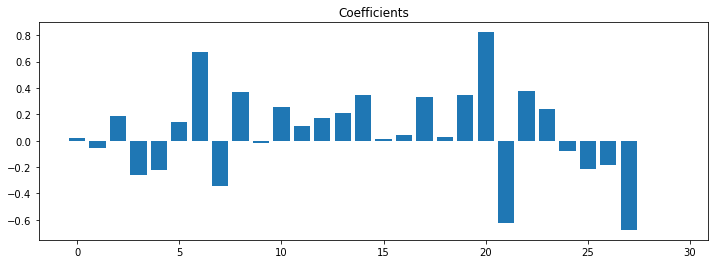

In [17]:
coeff = lrModel.coefficients.values
plt.figure(figsize = (12, 4))
plt.title("Coefficients")
ax = plt.bar(range(len(coeff)), coeff)
print ("Intercept: {:.3f}".format(lrModel.intercept))

In [18]:
summary = lrModel.summary
results_train = {
    'Accuracy': summary.accuracy,
    'AUC': summary.areaUnderROC,
    'FPR': summary.weightedFalsePositiveRate,
    'TPR': summary.weightedTruePositiveRate,
    'F score': summary.weightedFMeasure(),
    'Precision': summary.weightedPrecision,
    'Recall': summary.weightedRecall
}

result_train = pd.DataFrame(results_train, index=[0]).T
result_train.columns = ['Train Measures']
result_train

,Train Measures
Accuracy,0.805126
AUC,0.852599
FPR,0.342549
TPR,0.805126
F score,0.799792
Precision,0.797778
Recall,0.805126


In [19]:
predictions = lrModel.transform(testprepDF)

evaluatorLR = BinaryClassificationEvaluator(
    rawPredictionCol = "prediction"
)

results = predictions.select(['prediction', 'label'])
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0]), float(i[1])) for i in results_collect]
predictionAndLabels = spark.sparkContext.parallelize(results_list)
metrics = BinaryClassificationMetrics(predictionAndLabels)

print("AuPR: {:.3f}".format(metrics.areaUnderPR))
print("AuROC: {:.3f}".format(metrics.areaUnderROC))
area_under_curve = evaluatorLR.evaluate(predictions)
print("AUC: {:.3f}".format(area_under_curve))

AuPR: 0.541
AuROC: 0.730
AUC: 0.730


In [20]:
# grid search
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20])
             .build())

In [21]:
cv = CrossValidator(
    estimator = lr, 
    estimatorParamMaps = paramGrid, 
    evaluator = evaluatorLR, 
    numFolds = 5
)

# run cross validations
cvModel = cv.fit(trainprepDF)

In [22]:
predictions = cvModel.bestModel.transform(testprepDF)

In [23]:
evaluatorLR.evaluate(predictions)

0.7245300247072726

In [24]:
# random forest model
rf = RandomForestClassifier(
    labelCol = "label", 
    featuresCol = "features"
).setImpurity("gini") \
.setMaxDepth(6) \
.setNumTrees(50) \
.setFeatureSubsetStrategy("auto") \
.setSeed(1010)

rfModel = rf.fit(trainprepDF)

In [25]:
predictions = rfModel.transform(testprepDF)

In [26]:
results = predictions.select(['prediction', 'label'])

count = predictions.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count

precision = tp/(tp+fp)

recall = tp/(tp+fn)

print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
      % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))


Correct: 1718
Wrong: 409
tp: 273
fp: 160
fn: 249
tn: 1445
Accuracy: 0.8077103902209685
Precision: 0.6304849884526559
Recall: 0.5229885057471264
